In [15]:
import pandas as pd
import datetime
from nltk.sentiment import SentimentIntensityAnalyzer

In [16]:
# Objetivo: Vamos a crear la conexión con BigQuery y vamos a leer mediante
# consulta SQL desde Python.
# Generamos conexion a bigquery

from google.oauth2 import service_account # para generar conexion
bq_cred = service_account.Credentials.from_service_account_file('cedar-pottery-388916-edca8400ae77.json')
query = """
    SELECT m.name, m.address, m.gmap_id, m.category, r.text, r.time
    FROM `cedar-pottery-388916.conjunto_2.gmap_metadata` AS m
    JOIN `cedar-pottery-388916.conjunto_2.gmap_reviews` AS r
    ON m.gmap_id = r.gmap_id
    LIMIT 2000000
"""
#Dialect standard: para usar BigQuery’s standard SQL dialect
gmap_ML_mood = pd.read_gbq(query, project_id='cedar-pottery-388916', credentials =bq_cred, dialect='standard')

In [18]:
gmap_ML_mood.drop(columns="gmap_id", inplace=True)
gmap_ML_mood = gmap_ML_mood.dropna(subset=['text','address','category','time'])

In [19]:
def convertir_tiempo_unix(tiempo_unix):
    # Convertir el tiempo Unix a segundos dividiendo por 1000
    tiempo_segundos = tiempo_unix / 1000
    # Crear un objeto datetime a partir del tiempo en segundos
    fecha_hora = datetime.datetime.fromtimestamp(tiempo_segundos)
    # Retornar la fecha y hora formateada
    return fecha_hora.strftime("%Y-%m-%d %H:%M:%S")

gmap_ML_mood["time"] = gmap_ML_mood["time"].apply(convertir_tiempo_unix)

# Convertir la columna entera a fechas
gmap_ML_mood['time'] = pd.to_datetime(gmap_ML_mood['time'])
gmap_ML_mood['Hour'] = pd.to_datetime(gmap_ML_mood['time'].dt.strftime('%H:%M:%S')).dt.time

gmap_ML_mood['time'] = pd.to_datetime(gmap_ML_mood['time']).dt.date


# Obtén el nombre de la última columna del DataFrame
last_column_name1 = gmap_ML_mood.columns[-1]
last_column_name2 = gmap_ML_mood.columns[-2]

# Extrae la última columna del DataFrame
last_column1 = gmap_ML_mood[last_column_name1]
last_column2 = gmap_ML_mood[last_column_name2]


# Elimina la última columna del DataFrame
gmap_ML_mood = gmap_ML_mood.drop(columns=[last_column_name1])
gmap_ML_mood = gmap_ML_mood.drop(columns=[last_column_name2])

# Inserta la columna extraída en la posición 2 del DataFrame
gmap_ML_mood.insert(1, last_column_name1, last_column1)
gmap_ML_mood.insert(2, last_column_name2, last_column2)



In [20]:
Abreviatura = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'NC', 'SC', 'CO', 'CT', 'ND', 'SD', 'DE',
    'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NJ', 'NY', 'NH', 'NM',
    'OH', 'OK', 'OR', 'PA', 'RI', 'TN', 'TX', 'UT', 'VT', 'VA', 'WV', 'WA',
    'WI', 'WY'
]

def filter_state(text):
    tokens = text.split()  # Divide el texto en palabras individuales
    for n in tokens:
        if n in Abreviatura:
            return n  # Retorna la sigla si se encuentra en la lista de abreviaturas
    return None  # Retorna None si no se encuentra ninguna sigla

gmap_ML_mood['State'] = gmap_ML_mood['address'].apply(filter_state)

In [21]:
gmap_ML_mood["category"] = gmap_ML_mood["category"].apply(eval)

def unificar_categoria(cat):
    return cat[0]

gmap_ML_mood["category"] = gmap_ML_mood["category"].apply(unificar_categoria)

In [22]:
lista_resultante = ['Shaving Ice', 'Weight Loss Centers', 'Eyelash salon', 'Barbershop', 'Nail salon', 'Tanning', 'Reflexology', "Women's clothing store", 'Perfume store', 'Massage', 'Massage Therapy', 'Spray Tanning', 'Beauty', 'Cosmetology Schools', 'Eyebrow Services', 'Shaved Snow', 'Jewelry engraver', 'Hair Extensions', 'Clothing alteration service', 'Skin care clinic', 'Nail Technicians', 'Beauty school', 'Day spa', 'Cosmetics store', 'Rolfing', 'Musical instrument repair shop', 'Shoe repair shop', 'Hair Stylists', 'Permanent Makeup', 'Tanning salon', 'Threading Services', 'Beauty product supplier', 'Beauty & Spas', 'Medical Spas', 'Beauty salon', 'Makeup artist', 'Photo shop', 'Boot repair shop', 'Blow Dry/Out Services', 'Body Contouring', 'Saunas', 'Hair removal service', 'Hair salon', 'Tattoo and piercing shop', 'Electrolysis hair removal service', 'Massage studio', 'Naturopathic/Holistic', 'Orthodontist', 'Spa', 'Clothing store', 'Makeup Artists', 'Beauty products wholesaler', 'Tattoo', 'Skin Care', 'Halotherapy', 'Facial spa', 'Sewing machine repair service', 'Quilt shop', 'Hair Removal', 'Eyelash Service', 'Hair Salons', 'Permanent make-up clinic', 'Cosmetics & Beauty Supply', 'Eyelash service', 'Piercing', 'Cosmetic dentist', 'Wig shop', 'Nail Salons', 'Camera store', 'Waxing']
gmap_ML_mood = gmap_ML_mood[gmap_ML_mood['category'].isin(lista_resultante)]

In [23]:
# Modelo de Machine Learning el cual detecta la polaridad del sentimiento con respecto a las reviews.

def get_sentiment(text):
    try:
        analyzer = SentimentIntensityAnalyzer()
        sentiment_scores = analyzer.polarity_scores(text)
        compound_score = sentiment_scores['compound']
        
        if compound_score > 0:
            return 'Positivo'
        elif compound_score < 0:
            return 'Negativo'
        else:
            return 'Neutral'
    except:
        return 'Error'

# Aplicar el análisis de sentimiento a la columna 'text' y crear la nueva columna 'sentiment'
gmap_ML_mood['sentiment'] = gmap_ML_mood['text'].apply(get_sentiment)

gmap_ML_mood.drop(columns=["address","text"], inplace=True)

In [24]:

# Obtén el nombre de la última columna del DataFrame
last_column_name = gmap_ML_mood.columns[-1]

# Extrae la última columna del DataFrame
last_column = gmap_ML_mood[last_column_name]

# Elimina la última columna del DataFrame
gmap_ML_mood = gmap_ML_mood.drop(columns=[last_column_name])

# Inserta la columna extraída en la posición 2 del DataFrame
gmap_ML_mood.insert(2, last_column_name, last_column)

gmap_ML_mood = gmap_ML_mood.reset_index(drop=True)

In [29]:
# Guarda el DataFrame modificado en un archivo CSV
gmap_ML_mood.to_csv('gmap_ML_mood.csv', index=False)

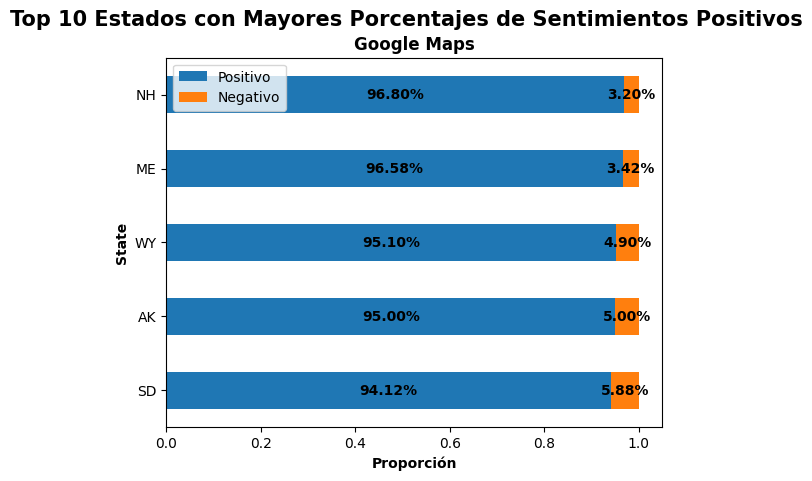

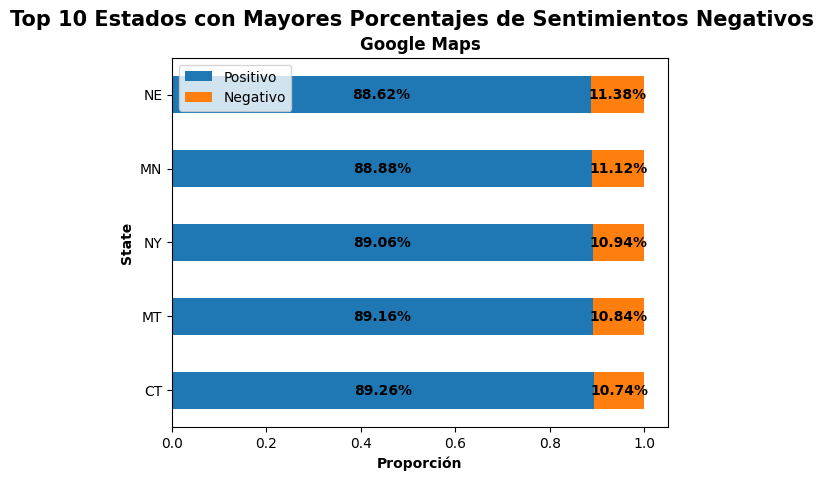

In [37]:
import pandas as pd
import matplotlib.pyplot as plt


# Calcular el recuento de sentimientos por estado
count_data = gmap_ML_mood.groupby(['State', 'sentiment']).size().unstack().fillna(0)

# Filtrar los estados sin valores
count_data = count_data.loc[count_data.sum(axis=1) > 0]

# Calcular las proporciones de los valores excluyendo la columna "Neutral"
prop_data = count_data[['Positivo', 'Negativo']].div(count_data[['Positivo', 'Negativo']].sum(axis=1), axis=0)

for graf in ["Positivo","Negativo"]:
# Ordenar el DataFrame por la columna 'Positivo' en orden descendente
    prop_data = prop_data.sort_values(by=graf, ascending=False)

# Tomar los primeros 10 estados con mayores porcentajes de sentimientos positivos
    top_10_states = prop_data.head(5)

# Crear el gráfico de barras horizontales con el orden invertido
    ax = top_10_states[::-1].plot(kind='barh', stacked=True)

# Configurar etiquetas y título
    plt.xlabel('Proporción', fontweight="bold")
    plt.ylabel('State', fontweight="bold")
    if graf == "Positivo":
        plt.suptitle('Top 10 Estados con Mayores Porcentajes de Sentimientos Positivos',fontsize=15,fontweight="bold")
        plt.title('Google Maps',fontweight="bold")
    else:
        plt.suptitle('Top 10 Estados con Mayores Porcentajes de Sentimientos Negativos',fontsize=15,fontweight="bold")
        plt.title('Google Maps',fontweight="bold")

# Mostrar la leyenda
    plt.legend()

# Agregar etiquetas en cada barra
    for rect in ax.patches:
        width = rect.get_width()
        label_text = f"{width:.2%}"  # Convertir el ancho a porcentaje con 2 decimales
        if width > 0:  # Verificar si el ancho es mayor que 0
            ax.text(rect.get_x() + width / 2, rect.get_y() + rect.get_height() / 2, label_text,
                    ha='center', va='center', color='black', fontweight="bold")

# Mostrar el gráfico
plt.show()


In [40]:
gmap_ML_mood.rename(columns={"name": "Nombre_Local", 
                             "Hour": "Hora",
                             "sentiment": "Sentimiento",
                             "time": "Fecha",
                             "category": "Servicio",
                             "State": "Estado"
                             }, inplace=True)

gmap_ML_mood

,Nombre_Local,Hora,Sentimiento,Fecha,Servicio,Estado
0,SmartStyle Hair Salon,14:02:59,Positivo,2019-03-09,Hair salon,CO
1,Cactus Curlers Beauty Salon,23:32:13,Positivo,2020-03-18,Beauty salon,AZ
2,Cactus Curlers Beauty Salon,15:23:49,Positivo,2020-12-04,Beauty salon,AZ
3,Cactus Curlers Beauty Salon,13:17:33,Positivo,2019-06-06,Beauty salon,AZ
4,Sophie Nails,15:21:36,Positivo,2019-08-05,Nail salon,NC
...,...,...,...,...,...,...
64841,Nails By Anh,17:07:59,Positivo,2020-09-23,Nail salon,FL
64842,Stacy Taylor Salon,14:46:36,Positivo,2021-04-16,Hair salon,FL
64843,Stacy Taylor Salon,12:50:27,Positivo,2018-01-06,Hair salon,FL
64844,Stacy Taylor Salon,08:07:39,Positivo,2020-10-03,Hair salon,FL
